In [2]:
# Basic packages
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd  # generating random numbers
import datetime  # manipulating date formats
# Viz
import matplotlib.pyplot as plt  # basic plotting
import seaborn as sns  # for prettier plots
import matplotlib.style as style
style.use('ggplot')

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import scipy.special as sc
from scipy.stats import invgamma 

plt.rcParams.update({'font.size': 14})

# settings
import warnings
warnings.filterwarnings("ignore")

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='ggplot',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        # Defining the subplot axes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        # Auto correlation plot(MA)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        # Parcial ACF(AR)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
        plt.plot()

# Parameter estimation AR(1) process

General autoregressive process with p-order **AR(p)**:
$$y_t = \left(\sum_{i=1}^{p}{\phi_i \cdot y_{t-i}}\right) + \epsilon_t$$

Usually the noise therm ($\epsilon_t$) is normally distributed with mean equal to zero and deviation $v$, as the following way:
$$\epsilon \sim \mathcal{N}(0,v)$$

In this exercise, we must to random generate an **AR(1)** sampling $\phi$ and $v$.
$$y_t = \phi \cdot y_{t-1} + \epsilon_t \;\;\;\; \epsilon \sim \mathcal{N}(0,v)$$
$$\phi \in [0.7,0.95]$$
$$v \in [0.75,2]$$

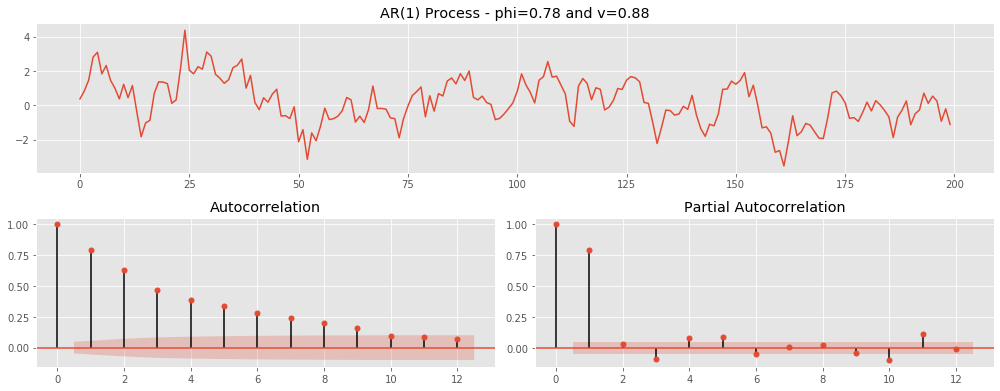

In [46]:
# Simulate an AR(1) process
#np.random.seed(42)
n_samples = int(200)
phi = np.random.uniform(low=0.7, high=0.95)
v = np.random.uniform(low=0.75, high=2)
y = e = np.random.normal(size=n_samples, loc=0, scale=v)

for t in range(1,n_samples):
    y[t] = phi*y[t-1] + e[t]

_ = tsplot(y, lags=12,title=f"AR(1) Process - phi={round(phi,2)} and v={round(v,2)}")

* Knowing that our process has errors following a normal distribution, the estimation via maximum likelihood is simply the OLS(Métodos minimos quadrados) approach to find /phi and v, so using this result we have that:


$$\widehat{\phi} = \frac{\frac{1}{T}\sum_{t=1}^{T} y_{t-1}\: y_{t}}{\frac{1}{T}\sum_{t=1}^{T} y_{t-1}^{2}}$$

$$\widehat{v} = \frac{1}{T}\sum_{t=1}^{T} \widehat{\varepsilon_{t}}^{2}$$

$$\widehat{\varepsilon_{t}} = y_{t}-\widehat{\phi}y_{t-1} $$

$$ T = n - p $$

In [47]:
def maximum_likelihood_ar_1(y, n_samples, p=1):
    T = n_samples - p
    
    # Finding phi estimate via OLS(maximum likelihood when errors = normal distribution)
    u = l = 0
    for t in range(1, T):
        u += y[t-1]*y[t]
        l += y[t-1]**2
        
    phi_hat = u/l
    
    # Finding v (error variance)
    v_hat = 0
    for t in range(1, T):
        v_hat += ((y[t] - phi_hat*y[t-1])**2)
    
    v_hat /= T
        
    return phi_hat, v_hat

In [48]:
real = phi, v

In [49]:
max_est = maximum_likelihood_ar_1(y, n_samples)

In [50]:
print(f'AR(1):\nReal/Actual Parameters: {real}\nEstimated Parameters Via Maximum-Likelihood {max_est}')

AR(1):
Real/Actual Parameters: (0.7761122108194803, 0.8766598003509585)
Estimated Parameters Via Maximum-Likelihood (0.7954131133213573, 0.6265932784884622)


### Bayesian Estimation

In [51]:
# USING MCMC

p = 1
y = y
n = n_samples
z = y[(p):n]
Ft = np.zeros((n-p, p))

for k in range(1, n-p):
    Ft[k, ] = y[(p+k-2): k]
    
F = Ft.T

invF = np.linalg.inv(np.matmul(F, Ft))

phi_hat = np.matmul(np.matmul(invF, F), z)

def fun(phi, z, Ft):
    e = np.matmul(z - Ft, phi)
    Q = np.matmul(e.T, e)
    return Q

def mcmc(z, p, ini, niter):
    z = z.reshape(len(z), 1)
    n = len(z)
    phi = np.zeros((niter, p))
    v = np.zeros(niter)
    phi[0, ] = ini[0:p]
    v[0] = ini[p]
    
    for m in range(1, niter):
        Q = fun(phi[m-1, ], z, Ft)
        v[m] = invgamma.rvs(n/2, scale=Q/2, size=1)[0]
        phi[m, ] = np.random.multivariate_normal(phi_hat, v[m]*invF, size=1)
        
    return phi, v

In [52]:
phi_, v_ = mcmc(z, 1, (phi_hat, 1.6), 1000)

AR(1)
Actual phi1=0.7761122108194803
Actual v=0.8766598003509585


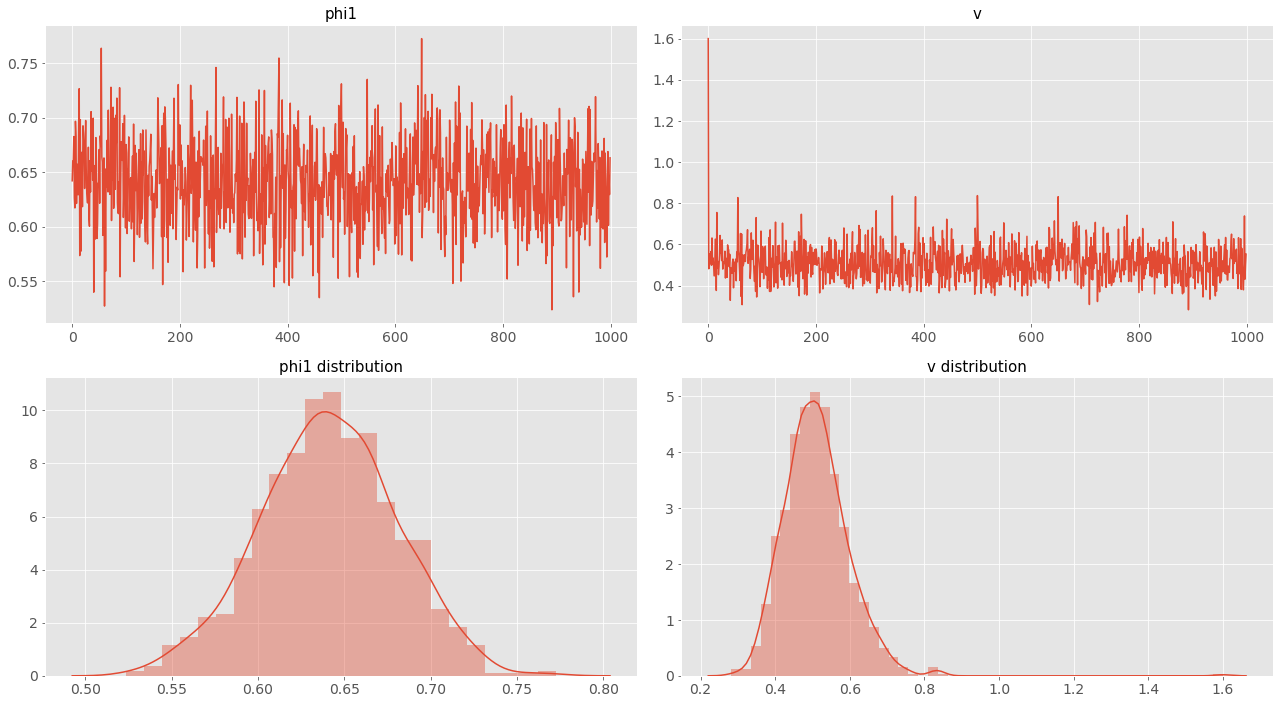

In [53]:
print(f'AR(1)\nActual phi1={phi}\nActual v={v}')
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(18, 10))

ax1[0].plot(phi_)

# Annual moving averages period = 12 months
ax1[1].plot(v_,)

ax1[0].set_title('phi1', fontsize=15)

ax1[1].set_title('v', fontsize=15)

sns.distplot(phi_, ax=ax2[0])
ax2[0].set_title('phi1 distribution', fontsize=15)

sns.distplot(v_, ax=ax2[1])
ax2[1].set_title('v distribution', fontsize=15)

plt.tight_layout()

In [54]:
print("The estimator to phi is:", phi_.mean())
print("The estimator to v is:", v_.mean())

The estimator to phi is: 0.6409010704412267
The estimator to v is: 0.5108619027645064


# Bayesian Forecasting to an AR(1) process

Given a sequence of T observations $\{X_t\}\;, t=1,2,...,T$ of an unknown time series, we want to model as an **AR(1)** process, so that:
$$y_t = y_{t-1}\phi + \epsilon_t \;\;, \epsilon_t \sim \mathcal{N(0,v)}$$

The modeling process was made using an Bayesian approach (previous item), thus $N$ values of the parameters was estimated to the *a posteriori* distribution: 
$$\theta^{(i)} = (\phi^{(i)}, v^{(i)}) \; i=1,...,N$$

In the Bayesian approach the statistical uncertainties of the parameters are taken into account to forecast values, thus, the one-step predictive distribution is:
$$p(y_{T+1}|y) = \int p(y_{T+1}|y,\phi,v) \cdot p(\phi|y) \; d\phi dv$$

To simulate values to $y_{T+1}$ we're use the $N$ values of the parameters, so that:
$$ 
    y_{T+1}^{(1)}|y_T,\phi^{(1)},v^{(1)} \sim \mathcal{N}(\phi^{(1)} \cdot y_T, v^{(1)}) \\ 
    y_{T+1}^{(2)}|y_T,\phi^{(2)},v^{(2)} \sim \mathcal{N}(\phi^{(2)} \cdot y_T, v^{(2)}) \\
    \vdots \\
    y_{T+1}^{(N)}|y_T,\phi^{(N)},v^{(N)} \sim \mathcal{N}(\phi^{(N)} \cdot y_T, v^{(N)})
$$

At the end, we use the predictive values of $y_{T+1}$ to estimate the punctual prevision:
$$E(Y_{T+1}|y) \approx \frac{1}{N} \sum_{j=1}^{N} y_{T+1}^{(j)}$$

The algorithm to predict h-steps forward becomes recursive, so that:
$$ 
    y_{T+h}^{(1)}|y_{T+h-1},\phi^{(1)},v^{(1)} \sim \mathcal{N}(\phi^{(1)} \cdot y_{T+h-1}, v^{(1)}) \\ 
    y_{T+h}^{(2)}|y_{T+h-1},\phi^{(2)},v^{(2)} \sim \mathcal{N}(\phi^{(2)} \cdot y_{T+h-1}, v^{(2)}) \\
    \vdots \\
    y_{T+h}^{(N)}|y_{T+h-1},\phi^{(N)},v^{(N)} \sim \mathcal{N}(\phi^{(N)} \cdot y_{T+h-1}, v^{(N)})
$$

And,
$$E(Y_{T+h}|y_{T+h-1}) \approx \frac{1}{N} \sum_{j=1}^{N} y_{T+h-1}^{(j)}$$

---
*Note*:  

Given an AR(1) process $y_t = y_{t-1}\phi + \epsilon_t \;\;, \epsilon_t \sim \mathcal{N(0,v)}$, implies that $y_t|y_{t-1} \sim \mathcal{N}(\phi \cdot y_{t-1},v)$

In [55]:
def beyesian_forecast(phi, v, y, steps):
    if len(phi) != len(v):
        return "phi and v must have same length"
    
    N = len(phi)
    y_predict = np.zeros(N)
    result = list()
    
    for s in range(steps):
        for phi_, v_,i in zip(phi, v, range(N)):
            y_predict[i] = np.random.normal(phi_*y, v_)
        y = y_predict.mean()
        result.append(y)
        
    return result

In [56]:
beyesian_forecast(phi_[200:],v_[200:],y[-6],6)

[0.08810119727262075,
 0.044099889038204075,
 0.033683841885497806,
 0.03312074191678727,
 0.024572870821360747,
 0.0478191741547731]

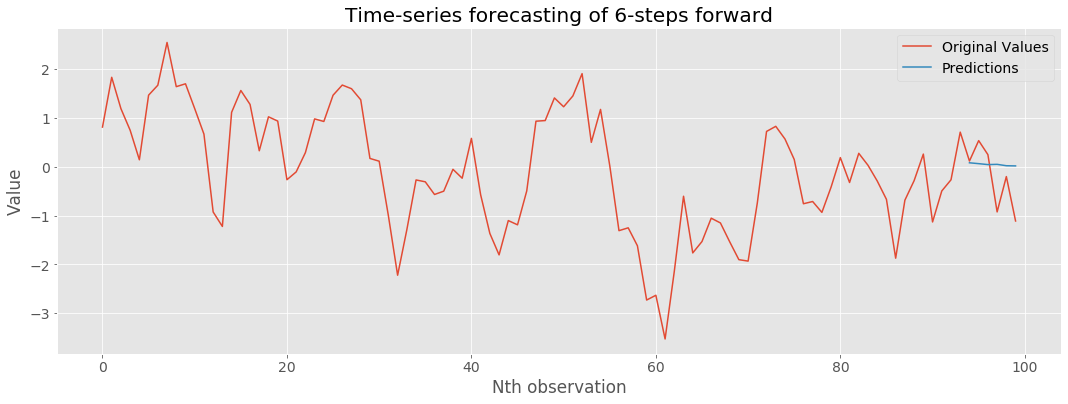

In [61]:
values_df = pd.DataFrame()
values_df['Original Values'] = y[100:]

pred_df = pd.DataFrame()
pred_df['Predictions'] = beyesian_forecast(phi_[200:],v_[200:],y[-6],6)
pred_df.index = pd.RangeIndex(start=94,stop=100,step=1)

fig, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.set_title("Time-series forecasting of 6-steps forward")
ax.set_xlabel("Nth observation")
ax.set_ylabel("Value")
pd.merge(values_df,pred_df,how='outer', left_index=True, right_index=True).plot(ax=ax)
plt.show()